# Lab 7 - Deep Learning 2

The goal of this week's lab is to learn to use two widely-used neural network modules: convolutional neural networks (CNNs) and recurrent neural networks (RNNs). We can use them to extract features from images and text.

![image](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)

Images and text are common data modalities we encounter in classification or generation tasks. While we can directly apply the linear or multi-linear perceptron (MLP) modules we learned in the past few weeks to those modalities, there are neural network modules specifically designed for processing them, namely CNNs and RNNs.

This week we will walk through the basics of CNNs and RNNs.

* **Review**: Training and Multi-Layer Perceptrons (MLPs)
* **Unit A**: Convolution Neural Networks (CNNs)
* **Unit B**: Recurrent Neural Networks (RNNs)

## Review

Last time we took a look at what's happening inside training when we call `model.fit`. We did this by implementing `model.fit` ourselves.

In [1]:
import altair as alt
import pandas as pd
import tensorflow as tf
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation

We will also turn off warnings.

In [2]:
import warnings
warnings.filterwarnings('ignore')

We first load the data.

In [3]:
df = pd.read_csv("https://srush.github.io/BT-AI/notebooks/circle.csv")
all_df = pd.read_csv("https://srush.github.io/BT-AI/notebooks/all_points.csv")

Next, we need to define a function that creates our model.

In [4]:
def create_model(learning_rate=1.0):
    # Makes it the same for everyone in class
    tf.random.set_seed(2)

    # Create model
    model = Sequential()
    model.add(Dense(1, activation="sigmoid"))

    # Compile model
    optimizer = tf.keras.optimizers.SGD(
        learning_rate=learning_rate
    )
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model

Then we create the model and implement training ourselves instead of directly calling `model.fit`. The basic idea is to first compute the loss, then adjust parameters to decrease the loss at each iteration. We use a learning rate as a factor to control how much we change the parameters per iteration.

In [5]:
model = create_model(learning_rate=1.0)
X = df[["feature1", "feature2"]]
y = df["class"] == "red"
X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)
pick = []
for i in range(400):
    # Compute loss
    with tf.GradientTape() as tape: 
        loss = model.compiled_loss(y, model(X, training=True))

    # Compute derivatives
    gradients = tape.gradient(loss, model.trainable_variables)

    # Adjust parameters
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Save for graphing.
    if i % 16 == 0:
        t = all_df.copy()
        t["predict"] = model.predict(all_df[["feature1", "feature2"]]) > 0.5
        pick.append(t)

In [6]:
# Now we can visualize how the classifier fits the data better and better over time.
chart = (alt.Chart(df)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color="class",
    ))
vc = alt.vconcat()
for p in pick: 
    chart2 = (alt.Chart(p)
              .mark_point(color="white")
              .encode(
                  x = "feature1",
                  y = "feature2",
                  fill = "predict" 
              ))
    vc &= (chart2 + chart)
vc

alt.VConcatChart(...)

### Review Exercise

Change the model above to an MLP and visualize how the classifier improves over time. 

In [7]:
#📝📝📝📝 FILLME
pass
# SOLUTION
def create_model(learning_rate):
    # Makes it the same for everyone in class
    tf.random.set_seed(2)

    # Create model
    model = Sequential()
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    # Compile model
    optimizer = tf.keras.optimizers.SGD(
        learning_rate=learning_rate
    )
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model
model = create_model(learning_rate=1)
X = df[["feature1", "feature2"]]
y = df["class"] == "red"
X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)
pick = []
for i in range(400):
    # Compute loss
    with tf.GradientTape() as tape:
        loss = model.compiled_loss(y, model(X, training=True))

    # Compute derivatives
    gradients = tape.gradient(loss, model.trainable_variables)

    # Adjust parameters
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Save for graphing.
    if i % 16 == 0:
        t = all_df.copy()
        t["predict"] = model.predict(all_df[["feature1", "feature2"]]) > 0.5
        pick.append(t)
# Now we can visualize how the classifier fits the data better and better over time.
chart = (alt.Chart(df)
    .mark_point()
    .encode(
        x = "feature1",
        y = "feature2",
        color="class",
    ))
vc = alt.vconcat()
for p in pick:
    chart2 = (alt.Chart(p)
              .mark_point(color="white")
              .encode(
                  x = "feature1",
                  y = "feature2",
                  fill = "predict"
              ))
    vc &= (chart2 + chart)
vc

alt.VConcatChart(...)

## Unit A

### MLP for Image Classification
Let's start with an image classification task. We will be using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), where the goal is to recognize handwritten digits.

In [8]:
df_train = pd.read_csv('mnist_train.csv.zip', compression='zip')
df_test = pd.read_csv('mnist_test.csv.zip', compression='zip')
df_train

label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0          5    0    0    0    0    0    0    0    0    0  ...      0      0   
1          0    0    0    0    0    0    0    0    0    0  ...      0      0   
2          4    0    0    0    0    0    0    0    0    0  ...      0      0   
3          1    0    0    0    0    0    0    0    0    0  ...      0      0   
4          9    0    0    0    0    0    0    0    0    0  ...      0      0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
59995      8    0    0    0    0    0    0    0    0    0  ...      0      0   
59996      3    0    0    0    0    0    0    0    0    0  ...      0      0   
59997      5    0    0    0    0    0    0    0    0    0  ...      0      0   
59998      6    0    0    0    0    0    0    0    0    0  ...      0      0   
59999      8    0    0    0    0    0    0    0    0    0  ...      0      0   

       28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0          0      0      0      0      0      0      0      0  
1          0      0      0      0      0      0      0      0  
2          0      0      0      0      0      0      0      0  
3          0      0      0      0      0      0      0      0  
4          0      0      0      0      0      0      0      0  
...      ...    ...    ...    ...    ...    ...    ...    ...  
59995      0      0      0      0      0      0      0      0  
59996      0      0      0      0      0      0      0      0  
59997      0      0      0      0      0      0      0      0  
59998      0      0      0      0      0      0      0      0  
59999      0      0      0      0      0      0      0      0  

[60000 rows x 785 columns]

The column "label" stores the label of each image, which is a number between 0 and 9; the rest of columns store the pixel values at each position in the image: for instance, the column "3x4" stores the pixel value at the 3rd row and the 4th column. Since the size of each image is 28x28, there are 28 rows and 28 columns. (If you are familiar with image processing, you might notice that there is only a single channel here, meaning there's only a single pixel value at each position, whereas images normally use 3 channels, meaning there's a value for each of the Red, Green, and Blue channels at each position. That's because MNIST is a dataset of grayscale images.)

To make later processing easier, we store the names of pixel value columns in a list `features`.

In [9]:
features = [f'{i}x{j}' for i in range(1, 29) for j in range(1, 29)]

To get a sense of what those images look like, we can use the following function to visuailze some images.

label:  5


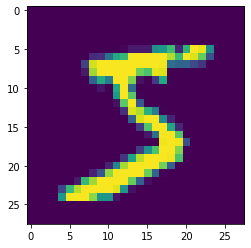

label:  0


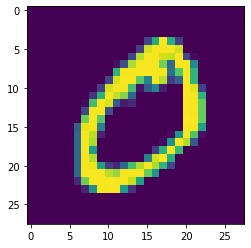

label:  4


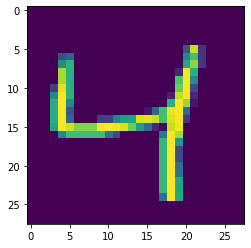

label:  1


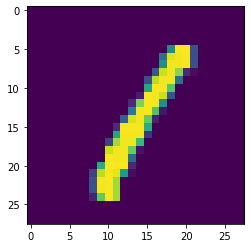

label:  9


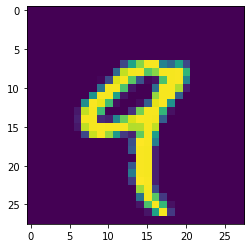

label:  2


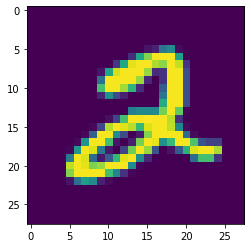

label:  1


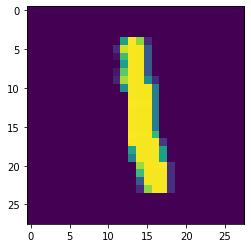

label:  3


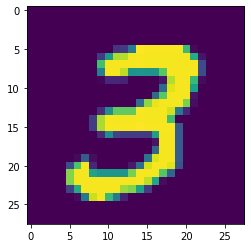

label:  1


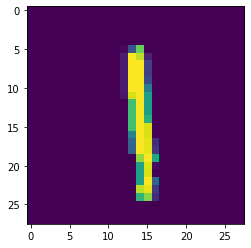

label:  4


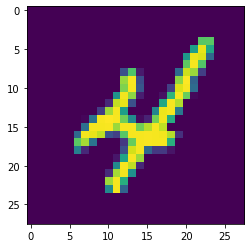

In [10]:
import matplotlib.pyplot as plt
def visualize_mnist(pixel_values):
    image = tf.convert_to_tensor(pixel_values)
    plt.imshow(tf.reshape(image, (28, 28)))
    plt.show()
for idx in range(10):
    example = df_train.loc[idx]
    pixel_values = example[features]
    label = example['label']
    print ('label: ', label)
    visualize_mnist(pixel_values)

Note that the variable `pixel_values` is a flat vector: it flattens the 28x28 image into a vector of size 784, so we reshaped it into 28x28 in the function `visualize_mnist`.

How can we solve this task? We can use the MLP classifier we learned last week, with a few modifications to change from binary classification to multi-class (10-way in this case) classification: first, the final layer needs to output a vector of size 10, which we denote by $\mathbf{l}$; second, we need to use a `softmax` activation function to normalize this vector into valid probabilities:

$\text{softmax}(\mathbf{l}) = \mathbf{p}$, where

$p_i = \frac{\exp(l_i)}{\sum_{j=1}^{10} \exp(l_j)}$ for $i=1, \ldots, 10$. 

We use $p_i$ to parameterize the predicted probability of the label being $i$. The $\exp$ operation in softmax ensures that the results are all non-negative, and then we divide by their summation to make sure that they add up to 1 (verify that $\sum_i p_i=1$ yourself).

Lastly, we need to change the loss function to `sparse_categorical_crossentropy`, which computes $-\log P(\text{label})$ so minimizing the loss is equivalent to maximizing the log likelihood of true labels under our model.

Let's adapt the MLP classifier we used last week to this problem:

In [11]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(64))
    model.add(Activation("relu"))
    model.add(Dense(10)) # output a vector of size 10
    model.add(Activation("softmax")) # use softmax to get valid probabilities
    # Compile model
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    return model

In [12]:
# create model
model = KerasClassifier(build_fn=create_model,
                        epochs=2,
                        batch_size=20,
                        verbose=0)
# fit model
model.fit(x=df_train[features].astype(float), y=df_train["label"])
# print summary
#print (model.model.summary())
# predict on test set
df_test["predict"] = model.predict(df_test[features])
correct = (df_test["predict"] == df_test["label"])
accuracy = correct.sum() / correct.size
print ("accuracy: ", accuracy)

accuracy:  0.9219


This simple MLP classifier was able to get 90% accuracy! 

👩<200d>🎓**Student question: what is the size of the input to the model??**

In [13]:
#📝📝📝📝 FILLME
pass
# SOLUTION
784

784

It is hard to visualize the behavior of the classifier under such a high dimensionality. Instead we can look at some examples that the classifier gets wrong:

true label: 5, predicted label: 4


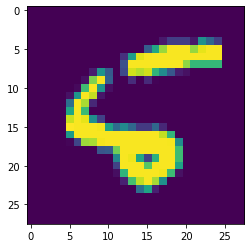

true label: 3, predicted label: 8


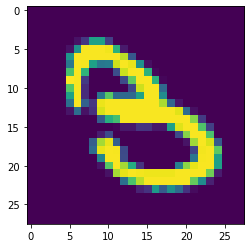

true label: 4, predicted label: 0


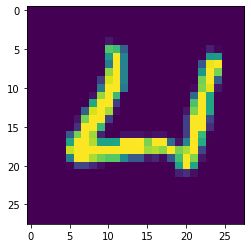

true label: 2, predicted label: 3


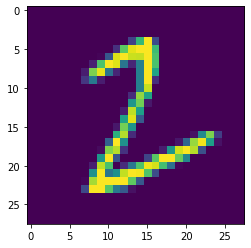

true label: 4, predicted label: 9


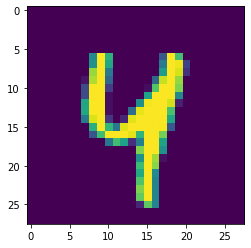

true label: 1, predicted label: 8


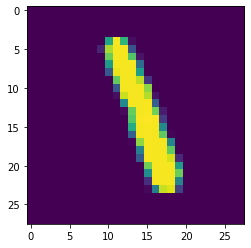

true label: 6, predicted label: 8


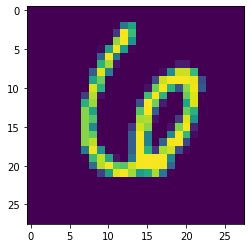

true label: 2, predicted label: 7


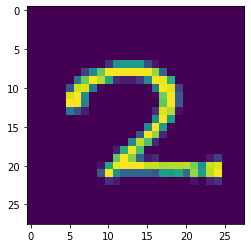

true label: 7, predicted label: 8


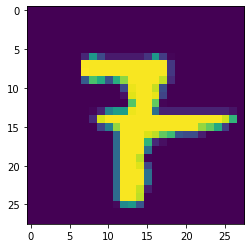

true label: 7, predicted label: 9


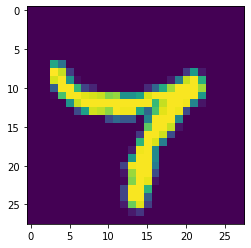

true label: 4, predicted label: 9


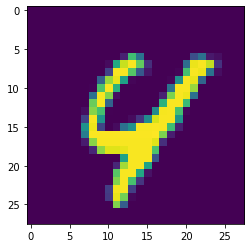

In [14]:
wrong = (df_test["predict"] != df_test["label"])
examples = df_test.loc[wrong]
num = 0
for idx, example in examples.iterrows():
    pixel_values = example[features]
    label = example['label']
    predicted_label = example["predict"]
    print (f'true label: {label}, predicted label: {predicted_label}')
    visualize_mnist(pixel_values)
    num += 1
    if num > 10:
        break

### MLP for Shuffled Image Classification

While MLP classifiers reach a decent accuracy on this task, it doesn't take into account locations in the model. To see this, let's shuffle each image in MNIST using the **same** shuffling order.

label: 5


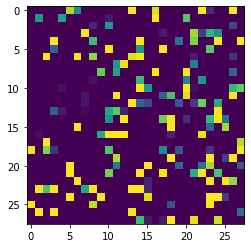

label: 0


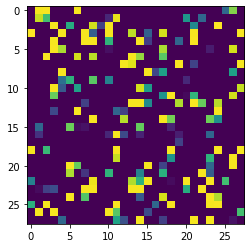

label: 4


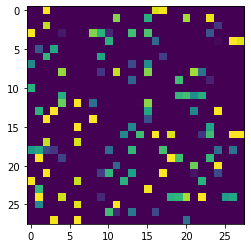

label: 1


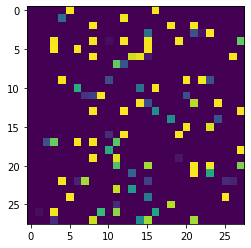

label: 9


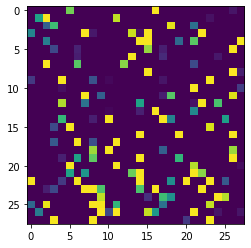

label: 2


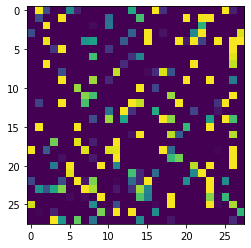

In [15]:
from sklearn.utils import shuffle
random_state = 1234
shuffled_features = shuffle(features, random_state=random_state)
num = 0
for idx, example in df_train.iterrows():
    pixel_values = example[shuffled_features]
    label = example['label']
    print (f'label: {label}')
    visualize_mnist(pixel_values)
    num += 1
    if num > 5:
        break

👩<200d>🎓**Student question: can you recognize what those images are? Train an MLP classifier on the shuffled images and report the test accuracy. (Hint: replace every `features` with `shuffled_features`)**

In [16]:
#📝📝📝📝 FILLME
pass
# SOLUTION
# create model
model = KerasClassifier(build_fn=create_model,
                        epochs=2,
                        batch_size=20,
                        verbose=0)
# fit model
model.fit(x=df_train[shuffled_features].astype(float), y=df_train["label"])
# print summary
#print (model.model.summary())
# predict on test set
df_test["predict"] = model.predict(df_test[shuffled_features])
correct = (df_test["predict"] == df_test["label"])
accuracy = correct.sum() / correct.size
print ("accuracy: ", accuracy)

accuracy:  0.9067


If you implemented correctly, you should see that the test accuracy on the shuffled images is similar to that on the original images. Think for a moment why shuffling doesn't change the accuracy much.

MLPs do not take into account locations in the input as humans do. For instance, the model is not aware that the pixel at position (i, j) is closer to the pixel at position (i+1, j) compared to position (i+10, j). For instance, if we swap the input feature i with the input feature j, and at the same time also swap the weights connected to i with the weights connected to j, we would end up with the same results after the first layer. We can see this by training a model on the original MNIST images, and then directly shuffle the input weights to get a model that works on the shuffled images:

In [17]:
# create model
model = KerasClassifier(build_fn=create_model,
                        epochs=2,
                        batch_size=20,
                        verbose=0)
# fit model
model.fit(x=df_train[features].astype(float), y=df_train["label"])
# predict on test set
df_test["predict"] = model.predict(df_test[features])
correct = (df_test["predict"] == df_test["label"])
accuracy = correct.sum() / correct.size
print ("the accuracy of the original model on the original MNIST dataset: ", accuracy)
# predict on shuffled test set
df_test["predict"] = model.predict(df_test[shuffled_features])
correct = (df_test["predict"] == df_test["label"])
accuracy = correct.sum() / correct.size
print ("the accuracy of the original model on the shuffled MNIST dataset: ", accuracy)
#
# shuffle input weights, no need to memorize how to do this
input_layer = model.model.layers[0]
weights, biases = input_layer.get_weights()
shuffled_weights = shuffle(weights, random_state=random_state)
input_layer.set_weights([shuffled_weights, biases])
#
# predict on shuffled test set
df_test["predict"] = model.predict(df_test[shuffled_features])
correct = (df_test["predict"] == df_test["label"])
accuracy = correct.sum() / correct.size
print ("the accuracy of the shuffled model on the shuffled MNIST dataset: ", accuracy)

the accuracy of the original model on the original MNIST dataset:  0.9064


the accuracy of the original model on the shuffled MNIST dataset:  0.1159


the accuracy of the shuffled model on the shuffled MNIST dataset:  0.9064


So we can see that an MLP classifier does not take into account the spatial information: it's simply maintaining a different weight for each input feature, and there is no sense of "closeness" between pixels that are spatially close to each other. It's not built to be translation-invariant: for example, if the digit in the image is shifted by one pixel to the right, the output of MLP is likely to be very different.

### Convolutional Neural Networks
#### The Convolution Operation

Convolutional Neural Networks (CNNs) are commonly used to extract features from images and time series. It takes into account the spatial information, allows matching local patterns (we'll see in a moment what it means), and it is robust under translation: it reacts similarly to an image and its shifted version.

Let's first define a CNN layer in the 2-D case (such as MNIST images). For now let's assume that the input of the CNN layer is a 2-D matrix, and the output of the CNN layer is also a 2-D matrix, usually of a smaller size compared to the input (without input padding). The parameters of a CNN layer are stored in a kernel (or a filter), which is a matrix (usually of a small size such as 3x3).

To get the output of the CNN layer, we overlay the kernel/filter on top of the input such that it covers part of the input without crossing the image boundary. We start from the upperleft corner, and traverse the input in a row-major order. At each overlay position, we multiply the kernel/filter matrix with the corresponding portion of the input **element-wise**, and take the sum of the result to fill in the corresponding slot in the output matrix. The size of the output matrix is determined by the number of possible overlay positions. This process is illustrated below.

In this illustration, the input shown in blue is of size 4x4, and the kernel/filter shown in pink is of size 2x2. The output size 3x3 is determined by the input size and the kernel/filter size. The paramters of the kernel/filter are
$\begin{bmatrix}1 & 0 \\ 1 & 1\end{bmatrix}$,
which is shown in white followed by a "$\times$". 

The upperleft corner of the output is calculated as $1\times1 + 0\times0 + 0\times1 + 1\times1=2$.

![image](imgs/1.png)

Now we shift the kernel/filter to its right. The next value of the output is calculated as $0\times1 + 1\times0 + 1\times1 + 1\times1=2$.

![image](imgs/2.png)

We shift the kernel/filter to its right again. The next value of the output is calculated as $1\times1 + 0\times0 + 1\times1 + 1\times1=3$.

![image](imgs/3.png)

We can't shift the kernel/filter to the right any more since doing so would cross the boundary. Therefore, we start from the first column of the second row (this is also known as the row-major traversing order since we traverse each row before going to the next). The next value of the output is calculated as $0\times1 + 1\times0 + 0\times1 + 1\times1=1$.

![image](imgs/4.png)

Moving right again, the next value of the output is calculated as $1\times1 + 1\times0 + 1\times1 + 0\times1=2$.

![image](imgs/5.png)

👩<200d>🎓**Student question: Now it is your turn to finish the result of the computations. Write down the full result of applying this CNN layer to the given input.**

In [18]:
#📝📝📝📝 FILLME
pass
# SOLUTION
# the rest of the output values are: 1, 1, 1, 0

👩<200d>🎓**Student question: If we increase the height of the input by 1, how would the size of the output change? If we increase the width of the kernel/filter by 1, how would the size of the output change?**

In [19]:
#📝📝📝📝 FILLME
pass
# SOLUTION
# The height of the output will also increase by 1 if we increase the height of the input by 1. The width of the output would decrease by 1 if we increase the width of the kernel/filter.

👩<200d>🎓**Student question: In the above illustrations, it seems that a CNN layer processes the input image in a sequential order. Are computations at different positions dependent upon each other? Can we use a different order such as starting from the bottom right corner? Can we parallelize the computations and compute them all at once using parallel hardware?**

In [20]:
#📝📝📝📝 FILLME
pass
# SOLUTION
# computations are independent of each other, we can use a different order, and we can parallelize them.

Technical jargon: the output of a convolution layer is often referred to as a feature map.

#### Pattern Matching

CNNs can match patterns with proper kernel weights. For instance, if we set the kernel/filter to be $\begin{bmatrix}-0.5 & 0.5 \\ -0.5 & 0.5\end{bmatrix}$, it can detect vertical edges.

In the below example, the first column of the output takes values 1, corresponding to the presence of an edge between the first column (all 0's) and the second column (all 1's) in the input image.

![image](imgs/edge1.png)

What if we shift the edge in the original input to the right by 1 pixel? We can see that the 1's in the output also shift to the right by 1.

![image](imgs/edge2.png)

Similarly, if we shift the edge to the right by 2 pixels, the 1's in the output shift to the right by 2.

![image](imgs/edge3.png)

👩<200d>🎓**Student question: design a kernel to detect edges in the horizontal direction.**

In [21]:
#📝📝📝📝 FILLME
pass
# SOLUTION
# $\begin{bmatrix}-0.5 & -0.5 \\ 0.5 & 0.5\end{bmatrix}$

#### Multiple Input and Output Channels

In practice, we want to go beyond only being able to detect a single type of edge, and we want to learn the kernel/filter weights automatically instead of setting them manually (a recurring theme in deep learning). Therefore, instead of only using a single kernel/filter, we use multiple "output channels", each with a different kernel/filter, such that each output channel can detect a different kind of pattern. The output shape is thereby augmented by an output channel dimension, forming a 3-D tensor of size (output height, output width, output channels).

Similarly, the input can also have multiple channels: for example, the input can be an RGB color image, or it can be the output of a previous CNN layer with multiple output channels. Therefore, instead of using a single kernel, we use one kernel per input channel, then apply the convolution operation to each input channel independently, and take the element-wise sum of the outputs from different input channels as the final output. This process is illustrated below, where for simplicity we only use a single output channel.

![image](imgs/multi_input_channels.png)

In practice, we also need to prepend a sample dimension such that we can process multiple samples all at once. For kernels, we need to append two additional dimensions, one for input channels, the other for output channels. Below is a summary of the shapes of these tensors.

1. input: (num samples, input height, input width, input channels).
2. output: (num samples, output height, output width, output channels).
3. kernel: (kernel height, kernel width, input channels, output channels).

The total number of parameters of the kernel can be calculated as input channels x kernel height x kernel width x output channels.

In the above discussions, we can see that a CNN layer can detect edges in the input image. By stacking multiple layers of CNNs together, it can learn to build up more and more sophisticated pattern matchers, detecting not only edges, but also mid-level and high-level patterns. 
To get a sense of how a CNN works in practice and the types of patterns it can match, let us look at the CNN Explainer. For now let's just play with the demo on the top of the website.

[CNN Explainer](https://poloclub.github.io/cnn-explainer/)

There are several things to look at in the tool.

1.  What's the height and width of the input image?
2. What's the number of the output channels of conv_1_1?
3. What kind of patterns does the model use for each image?

#### Strides and Padding
Let's take a look at how to create a CNN layer in Keras.
```
Conv2D(
   filters,
   kernel_size,
   strides=(1, 1),
   padding="valid",
   data_format=None,
   dilation_rate=(1, 1),
   groups=1,
   activation=None,
   use_bias=True,
   kernel_initializer="glorot_uniform",
   bias_initializer="zeros",
   kernel_regularizer=None,
   bias_regularizer=None,
   activity_regularizer=None,
   kernel_constraint=None,
   bias_constraint=None,
   **kwargs
)
```

It might appear intimidating, but most people only use the first three arguments: `filters`, `kernel_size`, and `strides` in addition to the argument `activation` for which we usually use "relu" as in MLPs. The argument `filters` specifies the number of output channels. The argument `kernel_size` is a tuple (height, width) specifying the size of the kernel. Now let's discuss what `strides` does, and we will also briefly cover `padding`.

In the above convolution layer examples, when we shift the kernel/filter to the right, we move by 1 pixel; similarly, when we move the kernel/filter down, we move down 1 pixel. We can generalize the step size of movements using strides. For example, we can use a stride of 2 along the width dimension, so we move by two pixels each time we move right (note that we still move down by 1 pixel since the stride along the height dimension is 1), resulting an output of size 3 x 2.

![image](imgs/stride1.png)

![image](imgs/stride2.png)

![image](imgs/stride3.png)

![image](imgs/stride4.png)

![image](imgs/stride5.png)

![image](imgs/stride6.png)

👩<200d>🎓**Student question: What would the output be if we use a stride of 2 both along the width dimension and the height dimension?**

In [22]:
#📝📝📝📝 FILLME
pass
# SOLUTION
# $\begin{bmatrix}2 & 3 \\ 1 & 0\end{bmatrix}$

Finally, let's briefly talk about padding. You might have noticed that in our first example, the output size is smaller than the input size:

![image](imgs/9.png)

This is the default behavior in Keras when `padding` is set to "valid". However, in some applications we may want the output to be of the same size as the input. In this case, we can pad the input image using zeros before applying the CNN layer. In Keras, when the argument `padding` is set to be "same",  the amount of padding is determined automatically such that the output size becomes the same as the input size.

![image](imgs/pad.png)

#### Convolution Layers in Keras

Now we are ready to implement a CNN layer in Keras! First, we need to import `Conv2D` from `keras.layers`.

In [23]:
from keras.layers import Conv2D

Now let's use Keras to verify the convolution results we calculated before.

![image](imgs/9.png)

Note that we need to do lots of reshapes to add the sample dimension, or the input/output channel dimension. To recap, the relevant shapes are:

1. input: (num samples, input height, input width, input channels).
2. output: (num samples, output height, output width, output channels).
3. kernel: (kernel height, kernel width, input channels, output channels).

In [24]:
input_shape = (1, 4, 4, 1) # 1 sample, height 4, width 4, 1 input channel
input = tf.convert_to_tensor([
    [1, 0, 1, 0],
    [0, 1, 1, 1],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
], dtype=tf.float32)
input = tf.reshape(input, input_shape)
#
kernel = tf.convert_to_tensor([
    [1., 0],
    [1, 1],
], dtype=tf.float32)
kernel_shape = (2, 2, 1, 1) # kernel height 2, kernel width 2, 1 input channel, 1 output channel
kernel = tf.reshape(kernel, kernel_shape)
#
cnn_layer = Conv2D(filters=1,  # filters specifies the number of output channels
                   kernel_size=(2, 2), 
)
cnn_layer(input) # hack to allocate memory for the kernel
cnn_layer.set_weights((kernel, tf.convert_to_tensor([0.]))) # biases are set to 0
#
output = cnn_layer(input)
print (tf.reshape(output, (3, 3)))

tf.Tensor(
[[2. 2. 3.]
 [1. 2. 1.]
 [1. 1. 0.]], shape=(3, 3), dtype=float32)


Yeah our calculations were correct!

#### Extension: Pooling Layer

In a convolution layer, we took the convolution between the kernel and a portion of the input to calculate the output. If we simply take the max value of that portion of input instead of using the convolution, we get a max pooling layer, as illustrated below. Note that a pooling layer does not have any parameters.

![image](imgs/max1.png)

![image](imgs/max2.png)

![image](imgs/max3.png)

![image](imgs/max4.png)

![image](imgs/max5.png)

![image](imgs/max6.png)

![image](imgs/max7.png)

![image](imgs/max8.png)

![image](imgs/max9.png)

Let's take a look at how to create a max pooling layer in Keras.
```
MaxPool2D(
    pool_size=(2, 2), 
    strides=None, 
    padding='valid', 
    data_format=None,
    **kwargs
)
```
Notice how similar it is to convolution layers? Can you infer what `strides` does here?

Now let's use Keras to verify the max pooling results above. 

In [25]:
from keras.layers import MaxPool2D
input_shape = (1, 4, 4, 1)
input = tf.convert_to_tensor([
    [1, 0, 1, 0],
    [0, 1, 1, 1],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
], dtype=tf.float32)
input = tf.reshape(input, input_shape)
pooling_layer = MaxPool2D(pool_size=(2, 2),
                          strides=(1, 1))
output = pooling_layer(input)
print (tf.reshape(output, (3, 3)))

tf.Tensor(
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 0.]], shape=(3, 3), dtype=float32)


In the above example we used `strides=(1,1)`. Hoever, the most common way of using a pooling layer is to set `strides` to be the same as `pool_size`, which is the default behavior if we don't set `strides`.

In [26]:
pooling_layer = MaxPool2D(pool_size=(2, 2))
output = pooling_layer(input)
print (tf.reshape(output, (2, 2)))

tf.Tensor(
[[1. 1.]
 [1. 0.]], shape=(2, 2), dtype=float32)


#### Extension: 1-D Convolutions

So far we've been discussing 2-D convolutions/pooling. We can apply what we discussed so far to 1-D cases: we can simply set the height of both the input and the kernel to 1, and what we've learned so far can be directly applied to 1-D objects such as time series or text if we view them as images of height 1.

#### Putting Everything Together

Now we can put everything together to build a full CNN classifier for MNIST classification. Below shows an example model, where we need to use a `Reshape` layer to reshape the input into a single-channel 2-D image, as well as a `Flatten` layer to flatten the feature map back to a vector.

In [27]:
from keras.layers import Flatten, Reshape

In [28]:
def create_cnn_model():
    # create model
    input_shape = (28, 28, 1)
    model = Sequential()
    model.add(Reshape(input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10)) # output a vector of size 10
    model.add(Activation("softmax")) # use softmax to get valid probabilities
    # Compile model
    model.compile(loss="sparse_categorical_crossentropy",
                   optimizer="adam",
                   metrics=["accuracy"])
    return model
 #
 # create model
model = KerasClassifier(build_fn=create_cnn_model,
                         epochs=2,
                         batch_size=20,
                         verbose=0)
# fit model
model.fit(x=df_train[features].astype(float), y=df_train["label"])
# print summary
#print (model.model.summary())
# predict on test set
df_test["predict"] = model.predict(df_test[features])
correct = (df_test["predict"] == df_test["label"])
accuracy = correct.sum() / correct.size
print ("accuracy: ", accuracy)

accuracy:  0.9794


We are able to get much bette accuracy than using MLPs!

# Group Exercise A

## Question 0

Icebreakers

Who are other members of your group today?

📝📝📝📝 FILLME

* What's their favorite flower or plant?

📝📝📝📝 FILLME

* Do they prefer to work from home or in the office?

📝📝📝📝 FILLME

## Question 1

Apply the CNN model to the shuffled MNIST dataset. What accuracy do you get? Is that what you expected?

In [29]:
#📝📝📝📝 FILLME
pass
model = KerasClassifier(build_fn=create_cnn_model,
                        epochs=2,
                        batch_size=20,
                        verbose=0)
# fit model
model.fit(x=df_train[shuffled_features].astype(float), y=df_train["label"])
# predict on test set
df_test["predict"] = model.predict(df_test[shuffled_features])
correct = (df_test["predict"] == df_test["label"])
accuracy = correct.sum() / correct.size
print ("accuracy: ", accuracy)

accuracy:  0.9375


## Question 2

For this question we will use the CNN Explainer website.

[CNN Explainer](https://poloclub.github.io/cnn-explainer/)

* Use the tool under the section "Understanding Hyperparameters" to figure out the output shape of each layer in the above CNN model.

In [30]:
#📝📝📝📝 FILLME
pass

* Use `print (model.model.summary())` to print the output shape of each layer. Did you get the same results as above?

In [31]:
#📝📝📝📝 FILLME
pass
# SOLUTION
#print (model.model.summary())

## Question 3

Let's apply our model to a different dataset, [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist), where the goal is to classify an image into one of the below 10 classes:
```
Label 	Description
0 	T-shirt/top
1 	Trouser
2 	Pullover
3 	Dress
4 	Coat
5 	Sandal
6 	Shirt
7 	Sneaker
8 	Bag
9 	Ankle boot
```

Some examples from the dataset are shown below, where each class takes three rows.

![image](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

We have processed the dataset into the same format as MNIST:

In [32]:
df_train = pd.read_csv('fashion_mnist_train.csv.zip', compression='zip')
df_test = pd.read_csv('fashion_mnist_test.csv.zip', compression='zip')
df_train

label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0          2    0    0    0    0    0    0    0    0    0  ...      0      0   
1          9    0    0    0    0    0    0    0    0    0  ...      0      0   
2          6    0    0    0    0    0    0    0    5    0  ...      0      0   
3          0    0    0    0    1    2    0    0    0    0  ...      3      0   
4          3    0    0    0    0    0    0    0    0    0  ...      0      0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
59995      9    0    0    0    0    0    0    0    0    0  ...      0      0   
59996      1    0    0    0    0    0    0    0    0    0  ...     73      0   
59997      8    0    0    0    0    0    0    0    0    0  ...    160    162   
59998      8    0    0    0    0    0    0    0    0    0  ...      0      0   
59999      7    0    0    0    0    0    0    0    0    0  ...      0      0   

       28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0          0      0      0      0      0      0      0      0  
1          0      0      0      0      0      0      0      0  
2          0     30     43      0      0      0      0      0  
3          0      0      0      1      0      0      0      0  
4          0      0      0      0      0      0      0      0  
...      ...    ...    ...    ...    ...    ...    ...    ...  
59995      0      0      0      0      0      0      0      0  
59996      0      0      0      0      0      0      0      0  
59997    163    135     94      0      0      0      0      0  
59998      0      0      0      0      0      0      0      0  
59999      0      0      0      0      0      0      0      0  

[60000 rows x 785 columns]

Let's visualize some examples first

label:  2


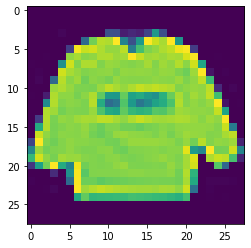

label:  9


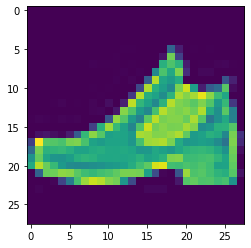

label:  6


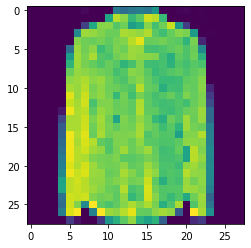

label:  0


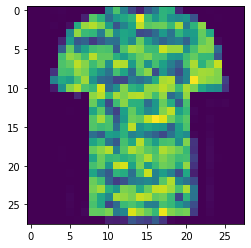

label:  3


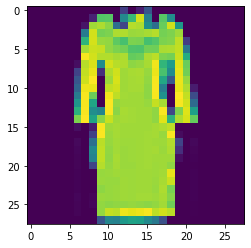

label:  4


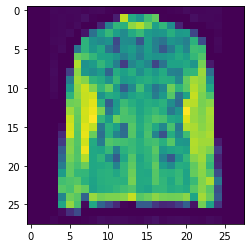

label:  4


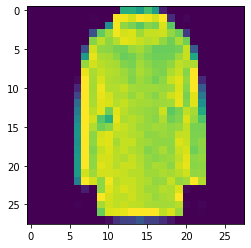

label:  5


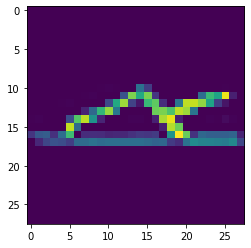

label:  4


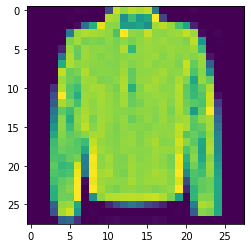

label:  8


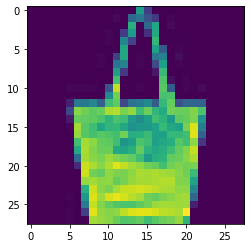

In [33]:
for idx in range(10):
    example = df_train.loc[idx]
    pixel_values = example[features]
    label = example['label']
    print ('label: ', label)
    visualize_mnist(pixel_values)

Apply the CNN model to this dataset and print out the accuracy.

In [34]:
#📝📝📝📝 FILLME
pass
#SOLUTION
# create model
model = KerasClassifier(build_fn=create_cnn_model,
                         epochs=2,
                         batch_size=20,
                         verbose=0)
# fit model
model.fit(x=df_train[features].astype(float), y=df_train["label"])
# print summary
print (model.model.summary())
# predict on test set
df_test["predict"] = model.predict(df_test[features])
correct = (df_test["predict"] == df_test["label"])
accuracy = correct.sum() / correct.size
print ("accuracy: ", accuracy)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (20, 28, 28, 1)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (20, 26, 26, 32)          320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (20, 13, 13, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (20, 11, 11, 64)          18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (20, 5, 5, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (20, 1600)                0         
_________________________________________________________________
dense_11 (Dense)             (20, 10)                 

accuracy:  0.855
